##### Import and preprocessing

only superpoint features

In [ ]:
! git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 81 (delta 12), reused 9 (delta 9), pack-reused 66
Unpacking objects: 100% (81/81), done.


In [ ]:
cd /content/SuperPointPretrainedNetwork

/content/SuperPointPretrainedNetwork


superpoint features + superglue matching

In [ ]:
!git clone https://github.com/magicleap/SuperGluePretrainedNetwork.git

Cloning into 'SuperGluePretrainedNetwork'...
remote: Enumerating objects: 182, done.
remote: Total 182 (delta 0), reused 0 (delta 0), pack-reused 182
Receiving objects: 100% (182/182), 118.85 MiB | 28.92 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Checking out files: 100% (89/89), done.


In [ ]:
cd /content/SuperGluePretrainedNetwork

/content/SuperGluePretrainedNetwork


imports and functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.spatial import KDTree
import cv2
from sklearn.preprocessing import normalize

import os
from google.colab import files
from google.colab import drive
from zipfile import ZipFile

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# truth
TRUTH_DATASET = 'ground_truth_color'

with ZipFile(f'/content/gdrive/MyDrive/{TRUTH_DATASET}.zip', 'r') as dataset_zip:
    dataset_zip.extractall(f'/content/{TRUTH_DATASET}')

In [ ]:
# restored results
for model_name in ['ARCNN', 'DNCNN3', 'FBCNN']:
    DATA = f'results_{model_name}'
    with ZipFile(f'/content/gdrive/MyDrive/{DATA}.zip', 'r') as dataset_zip:
        dataset_zip.extractall(f'/content/{DATA}')

In [3]:
# superpoint features
for model_name in ['ARCNN', 'DNCNN', 'FBCNN']:
    DATA = f'superpoint_{model_name}_10000'
    with ZipFile(f'/content/gdrive/MyDrive/{DATA}.zip', 'r') as dataset_zip:
        dataset_zip.extractall(f'/content/{DATA}')

###### functions

In [4]:
def download_folder_in_zip(dir_to_zip, output_filename, delete_dir_after_download=False):
    os.system( "zip -r {} {}".format(output_filename, dir_to_zip))
    if delete_dir_after_download:
        os.system( "rm -r {}".format( dir_to_zip ) )
    files.download(output_filename)

def make_path_txt(TRUTH_DATASET, RESTORED_DATASET, num_elements = 100):
    truth_list = []
    for image in os.listdir(f'/content/{TRUTH_DATASET}'):
        truth_list.append(f'/content/{TRUTH_DATASET}/{image}')
    truth_list = sorted(truth_list)[:num_elements]

    restored_list = []
    for image in os.listdir(f'/content/{RESTORED_DATASET}'):
        restored_list.append(f'/content/{RESTORED_DATASET}/{image}')
    restored_list = sorted(restored_list)[:num_elements]

    path_list = []
    for i in range(len(truth_list)):
        path_list.append('\n' + truth_list[i] + ' ' + restored_list[i])
    
    # remove simbol '\n' from first string
    path_list[0] = path_list[0][1::]

    # create files if they dont exists .txt
    with open("/content/pairs.txt", "w+") as textfile:
        for line in path_list:
            textfile.write(line)

# functions for superpoint coordinates matching
def get_cross_matches(matches1, matches2):
    """
    calculate cross match features
    """
    cross_matches = 0
    for k1, v1 in matches1.items():
        if v1 in matches2:
            if matches2[v1] == k1:
                cross_matches += 1
    return cross_matches

def get_key(d, value):
    for k, v in d.items():
        if np.array_equal(v, value):
            return k

def get_matches_with_scipy(kp_idx1: dict, kp_idx2: dict, radius = 1.0):
    """
    get simple matches for two dict of coordinates of features of images
    using KDTree from scipy for faster running
    """
    matches = {}
    for k1, v1 in kp_idx1.items():

        # finding nearest with KDTree
        tree = KDTree(list(kp_idx2.values()))
        nearest = tree.query(v1)
        # print('coordinates:', v1, list(kp_idx2.values())[nearest[1]], 'dist value:', nearest[0])

        if nearest[0] < radius:
            # key of the nearest in kp_idx2
            k2 = get_key(kp_idx2, list(kp_idx2.values())[nearest[1]])

            # save matching
            matches[k1] = k2

            # delete matching key
            del kp_idx2[k2]

    return matches

def superpoint_coord_match(keypoints1: dict, keypoints2: dict, radius = 1.0):
    """
    cross matching value using coordinates of features caclulated by superpoint
    """
    kp1 = deepcopy(keypoints1)
    kp2 = deepcopy(keypoints2)

    print('radius value:', radius)
    print('number of features for img1:', len(kp1))
    print('number of features for img2:', len(kp2))

    # simple match
    im1_VS_im2_match = get_matches_with_scipy(kp1, kp2, radius = radius)

    kp1 = deepcopy(keypoints1)
    kp2 = deepcopy(keypoints2)

    im2_VS_im1_match = get_matches_with_scipy(kp2, kp1, radius = radius)

    print('number of matches 1 VS 2:', len(im1_VS_im2_match))
    print('number of matches 2 VS 1:', len(im2_VS_im1_match))

    # cross_match
    cross_matches = get_cross_matches(im1_VS_im2_match, im2_VS_im1_match)
    cross_match_value = cross_matches/len(keypoints2)
    print('cross matches:', cross_matches)
    print('cross match value:', cross_match_value)

    return cross_match_value

def superpoint_coord_batch_match(keypoints1, keypoints2, radius = 1):
    '''
    coordinates based match for package
    '''
    kp1 = deepcopy(keypoints1)
    kp2 = deepcopy(keypoints2)

    match_values = []
    for i in range(len(kp1)):
        print('#'*50)
        print('pair', i)
        print()
        value = superpoint_coord_match(dict(enumerate(kp1[i])), 
                                       dict(enumerate(kp2[i])), 
                                       radius = radius)
        print()
        match_values.append(value)
    return match_values

def set_coord_des(kp, des):
    coord = {}
    descript = {}
    for i in range(len(kp)):
        coord[i] = np.array(kp[i].pt)

        descript[i] = des[i]
    return coord, descript

def get_idx_cross_matches(matches1, matches2):
    """
    calculate cross match features
    return matching idx
    """
    cross_matches = {}
    for k1, v1 in matches1.items():
        if v1 in matches2:
            if matches2[v1] == k1:
                cross_matches[v1] = k1
    return cross_matches

def dist_between_matched_descriptors(superpoint_kp_truth, superpoint_kp_arcnn, radius=1):

    kp1 = deepcopy(superpoint_kp_truth)
    kp2 = deepcopy(superpoint_kp_arcnn)

    print('radius value:', radius)
    print('number of features:', len(kp1))

    im1_VS_im2_match = get_matches_with_scipy(kp1, kp2, radius = radius)

    kp1 = deepcopy(superpoint_kp_truth)
    kp2 = deepcopy(superpoint_kp_arcnn)

    im2_VS_im1_match = get_matches_with_scipy(kp2, kp1, radius = radius)

    # cross_match
    cross_matches = get_idx_cross_matches(im1_VS_im2_match, im2_VS_im1_match)

    print('number of matching features:', len(cross_matches))

    return cross_matches

### superglue matching (+superpoint featuring)

###### running

In [ ]:
%%time
# ARCNN
make_path_txt('ground_truth_color', 'results_ARCNN')

!python match_pairs.py --input_pairs /content/pairs.txt --output_dir /content/superpoint_ARCNN --nms_radius 1 --resize -1 --max_keypoints 400 --viz --match_threshold 0.1

match_values_a = []
path = '/content/superpoint_ARCNN'
for pair in os.listdir(path):
    npz = np.load(path+'/'+pair)
    match_values_a.append(np.sum(npz['matches']>-1))
print('ARCNN mean value:', np.mean(np.array(match_values_a)))
download_folder_in_zip('/content/results_match_ARCNN', 'superpoint_ARCNN.zip')

Namespace(cache=False, eval=False, fast_viz=False, force_cpu=False, input_dir='assets/scannet_sample_images/', input_pairs='/content/pairs.txt', keypoint_threshold=0.005, match_threshold=0.1, max_keypoints=400, max_length=-1, nms_radius=1, opencv_display=False, output_dir='/content/superpoint_ARCNN', resize=[-1], resize_float=False, show_keypoints=False, shuffle=False, sinkhorn_iterations=20, superglue='indoor', viz=True, viz_extension='png')
Will not resize images
Running inference on device "cpu"
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
Looking for data in directory "assets/scannet_sample_images"
Will write matches to directory "/content/superpoint_ARCNN"
Will write visualization images to directory "/content/superpoint_ARCNN"
[Finished pair     0 of   100] load_image=0.223 matcher=26.163 viz_match=2.131 total=28.517 sec {0.0 FPS} 
[Finished pair     1 of   100] load_image=0.213 matcher=25.608 viz_match=2.103 total=27.924 sec {0.0 FPS} 
[Finished pair     2 o

ValueError: ignored

In [ ]:
%%time
# DNCNN
make_path_txt('ground_truth_color', 'results_DNCNN3')

!python match_pairs.py --input_pairs /content/pairs.txt --output_dir /content/superpoint_DNCNN --nms_radius 1 --resize -1 --max_keypoints 1000 --viz

match_values_d = []
path = '/content/superpoint_DNCNN'
for pair in os.listdir(path):
    npz = np.load(path+'/'+pair)
    match_values_d.append(np.sum(npz['matches']>-1))
print('DNCNN mean value:', np.mean(np.array(match_values_d)))
download_folder_in_zip('/content/results_match_DNCNN', 'superpoint_DNCNN.zip')

Namespace(cache=False, eval=False, fast_viz=False, force_cpu=False, input_dir='assets/scannet_sample_images/', input_pairs='/content/pairs.txt', keypoint_threshold=0.005, match_threshold=0.2, max_keypoints=10000, max_length=-1, nms_radius=1, opencv_display=False, output_dir='/content/superpoint_DNCNN', resize=[-1], resize_float=False, show_keypoints=False, shuffle=False, sinkhorn_iterations=20, superglue='indoor', viz=True, viz_extension='png')
Will not resize images
Running inference on device "cpu"
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
Looking for data in directory "assets/scannet_sample_images"
Will write matches to directory "/content/superpoint_DNCNN"
Will write visualization images to directory "/content/superpoint_DNCNN"
tcmalloc: large alloc 1600004096 bytes == 0x14bb0000 @  0x7f6dcc025b6b 0x7f6dcc045379 0x7f6d546ded57 0x7f6d546ccbc3 0x7f6d7e5d76af 0x7f6d7e5d8020 0x7f6d7e5d8074 0x7f6d7e5d81bf 0x7f6d7f35f82b 0x7f6d7f3c34c2 0x7f6d7e913726 0x7f6d7e8fdf4

FileNotFoundError: ignored

In [ ]:
%%time
# FBCNN
make_path_txt('ground_truth_color', 'results_FBCNN')

!python match_pairs.py --input_pairs /content/pairs.txt --output_dir /content/superpoint_FBCNN --nms_radius 1 --resize -1 --max_keypoints 1000 --viz --match_threshold 0.1

match_values_f = []
path = '/content/superpoint_FBCNN'
for pair in os.listdir(path):
    npz = np.load(path+'/'+pair)
    match_values_f.append(np.sum(npz['matches']>-1))
print('FBCNN mean value:', np.mean(np.array(match_values_f)))
download_folder_in_zip('/content/superpoint_FBCNN', 'superpoint_FBCNN.zip')

Namespace(cache=False, eval=False, fast_viz=False, force_cpu=False, input_dir='assets/scannet_sample_images/', input_pairs='/content/pairs.txt', keypoint_threshold=0.005, match_threshold=0.1, max_keypoints=1000, max_length=-1, nms_radius=1, opencv_display=False, output_dir='/content/superpoint_FBCNN', resize=[-1], resize_float=False, show_keypoints=False, shuffle=False, sinkhorn_iterations=20, superglue='indoor', viz=True, viz_extension='png')
Will not resize images
Running inference on device "cpu"
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
Looking for data in directory "assets/scannet_sample_images"
Will write matches to directory "/content/superpoint_FBCNN"
Will write visualization images to directory "/content/superpoint_FBCNN"
[Finished pair     0 of   100] load_image=0.265 matcher=32.087 viz_match=2.314 total=34.666 sec {0.0 FPS} 
[Finished pair     1 of   100] load_image=0.251 matcher=30.501 viz_match=2.286 total=33.039 sec {0.0 FPS} 
[Finished pair     2 

ValueError: ignored

###### visualization

In [ ]:
print('ARCNN mean:', np.mean(np.array(match_values_a)))
print('DNCNN mean:', np.mean(np.array(match_values_d)))
print('FBCNN mean:', np.mean(np.array(match_values_f)))

ARCNN mean: 5938.17
DNCNN mean: 6090.71
FBCNN mean: 6133.46


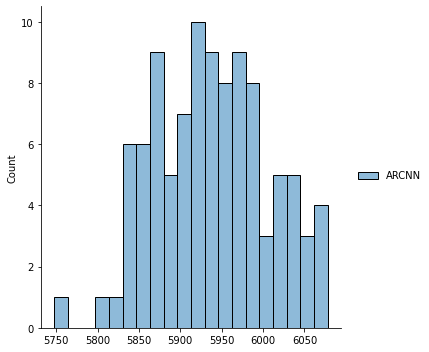

In [ ]:
data = pd.DataFrame({'ARCNN': match_values_a})
displot = sns.displot(data, bins = 20)
plt.show()

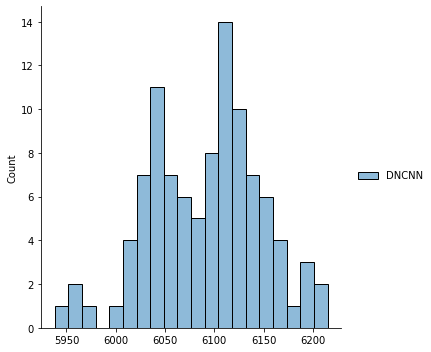

In [ ]:
data = pd.DataFrame({'DNCNN': match_values_d})
displot = sns.displot(data, bins = 20)
plt.show()

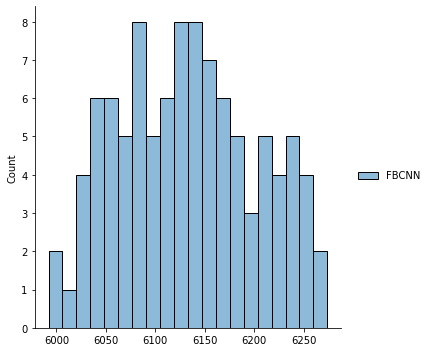

In [ ]:
data = pd.DataFrame({'FBCNN': match_values_f})
displot = sns.displot(data, bins = 20)
plt.show()

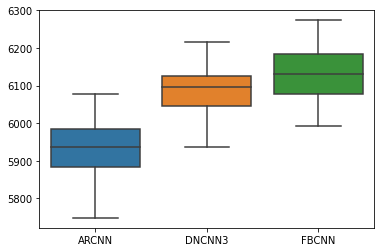

In [ ]:
data = pd.DataFrame({'ARCNN': match_values_a, 'DNCNN3': match_values_d, 'FBCNN': match_values_f})
sns.boxplot(data = data)
plt.show()

### coord matching

###### running

featuring

In [4]:
# ARCNN featuring

# make_path_txt(TRUTH_DATASET, ARCNN_DATASET)

# !python match_pairs.py --input_pairs /content/pairs.txt --output_dir /content/results_match_ARCNN --nms_radius 1 --resize -1 --max_keypoints 10000

kp_tr = {}
kp_a = {}
path = 'superpoint_ARCNN_10000/content/superpoint_ARCNN'
for i, pair in enumerate(os.listdir(path)):
    npz = np.load(path+'/'+pair)
    kp_tr[i] = npz['keypoints0']
    kp_a[i] = npz['keypoints1']

In [5]:
# DNCNN featuring

# make_path_txt(TRUTH_DATASET, DNCNN_DATASET)

# !python match_pairs.py --input_pairs /content/pairs.txt --output_dir /content/results_match_DNCNN --nms_radius 1 --resize -1 --max_keypoints 10000

# kp_tr = {}
kp_d = {}
path = 'superpoint_DNCNN_10000/content/superpoint_DNCNN'
for i, pair in enumerate(os.listdir(path)):
    npz = np.load(path+'/'+pair)
    # kp_tr[i] = npz['keypoints0']
    kp_d[i] = npz['keypoints1']

In [6]:
# FBCNN featuring
# make_path_txt(TRUTH_DATASET, FBCNN_DATASET)
# 
# !python match_pairs.py --input_pairs /content/pairs.txt --output_dir /content/results_match_FBCNN --nms_radius 1 --resize -1 --max_keypoints 10000

# kp_tr = {}
kp_f = {}
path = 'superpoint_FBCNN_10000/content/superpoint_FBCNN'
for i, pair in enumerate(os.listdir(path)):
    npz = np.load(path+'/'+pair)
    kp_tr[i] = npz['keypoints0']
    kp_f[i] = npz['keypoints1']

matching

In [ ]:
# ARCNN
arcnn_coord_match = superpoint_coord_batch_match(kp_tr, kp_a)
np.save('superpoint_arcnn_coord_match.npy', arcnn_coord_match)

In [ ]:
# DNCNN нужно от 0 до 46
dncnn_coord_match = superpoint_coord_batch_match(kp_tr, kp_d)
np.save('superpoint_dncnn_coord_match.npy', dncnn_coord_match)

##################################################
pair 0

radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of matches 1 VS 2: 1929
number of matches 2 VS 1: 1929
cross matches: 1929
cross match value: 0.1929

##################################################
pair 1

radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of matches 1 VS 2: 1837
number of matches 2 VS 1: 1837
cross matches: 1837
cross match value: 0.1837

##################################################
pair 2

radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of matches 1 VS 2: 1831
number of matches 2 VS 1: 1831
cross matches: 1831
cross match value: 0.1831

##################################################
pair 3

radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of matches 1 VS 2: 1847
number of matches 2 VS 1: 1847
cross matches: 1847
cross match

In [ ]:
# FBCNN
fbcnn_coord_match = superpoint_coord_batch_match(kp_tr, kp_f)
np.save('superpoint_fbcnn_coord_match.npy', fbcnn_coord_match)

##################################################
pair 0

radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of matches 1 VS 2: 2068
number of matches 2 VS 1: 2068
cross matches: 2068
cross match value: 0.2068

##################################################
pair 1

radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of matches 1 VS 2: 2013
number of matches 2 VS 1: 2013
cross matches: 2013
cross match value: 0.2013

##################################################
pair 2

radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of matches 1 VS 2: 2113
number of matches 2 VS 1: 2113
cross matches: 2113
cross match value: 0.2113

##################################################
pair 3

radius value: 1
number of features for img1: 10000
number of features for img2: 10000
number of matches 1 VS 2: 2083
number of matches 2 VS 1: 2083
cross matches: 2083
cross match

###### visualisation

In [7]:
drive.mount('/content/gdrive')

arcnn_coord_match = np.load('/content/gdrive/MyDrive/superpoint_arcnn_coord_match.npy')
dncnn_coord_match = np.load('/content/gdrive/MyDrive/superpoint_coord_matches_dncnn.npy')
fbcnn_coord_match = np.load('/content/gdrive/MyDrive/superpoint_matches_fbcnn.npy')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
dncnn_coord_match = np.array([float(value) for value in dncnn_coord_match])
fbcnn_coord_match = np.array([float(value) for value in fbcnn_coord_match])

In [10]:
print('ARCNN mean value:', np.mean(arcnn_coord_match))
print('DNCNN mean value:', np.mean(dncnn_coord_match))
print('FBCNN mean value:', np.mean(fbcnn_coord_match))

ARCNN mean value: 0.177323
DNCNN mean value: 0.18750899999999998
FBCNN mean value: 0.20457699999999998


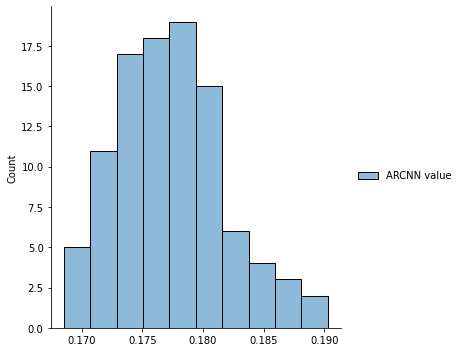

In [12]:
data = pd.DataFrame({'ARCNN value': arcnn_coord_match})
displot = sns.displot(data)
plt.show()

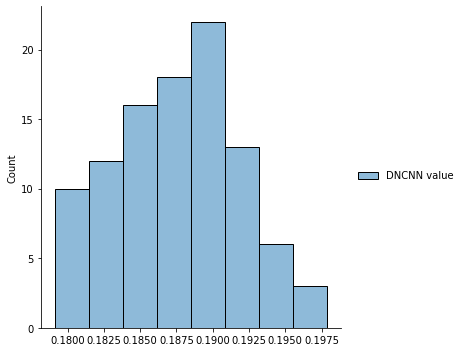

In [11]:
data = pd.DataFrame({'DNCNN value': dncnn_coord_match})
displot = sns.displot(data)
plt.show()

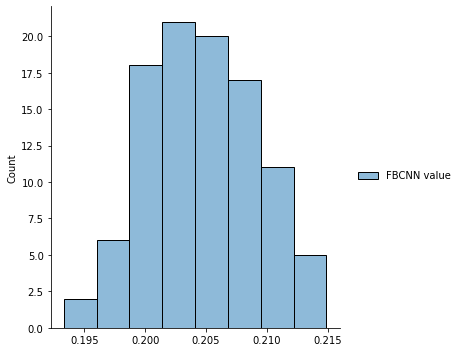

In [13]:
data = pd.DataFrame({'FBCNN value': fbcnn_coord_match})
displot = sns.displot(data)
plt.show()

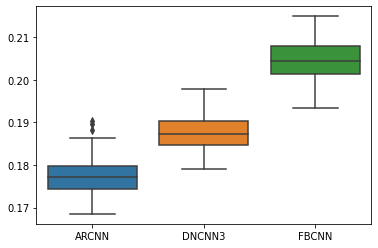

In [16]:
data = pd.DataFrame({'ARCNN': arcnn_coord_match, 'DNCNN3': dncnn_coord_match, 'FBCNN': fbcnn_coord_match})
sns.boxplot(data = data)
plt.show()

### distance between matching descriptors

In [ ]:
drive.mount('/content/gdrive')

x_truth = np.load('/content/gdrive/MyDrive/superpoint_keypoints_X_truth.npy')
y_truth = np.load('/content/gdrive/MyDrive/superpoint_keypoints_Y_truth.npy')
des_truth = np.load('/content/gdrive/MyDrive/superpoint_descriptors_truth.npy')

x_comp = np.load('/content/gdrive/MyDrive/superpoint_keypoints_X_comp.npy')
y_comp = np.load('/content/gdrive/MyDrive/superpoint_keypoints_Y_comp.npy')
des_comp = np.load('/content/gdrive/MyDrive/superpoint_descriptors_comp.npy')

x_arcnn = np.load('/content/gdrive/MyDrive/superpoint_keypoints_X_arcnn.npy')
y_arcnn = np.load('/content/gdrive/MyDrive/superpoint_keypoints_Y_arcnn.npy')
des_arcnn = np.load('/content/gdrive/MyDrive/superpoint_descriptors_arcnn.npy')

x_fbcnn = np.load('/content/gdrive/MyDrive/superpoint_keypoints_X_fbcnn.npy')
y_fbcnn = np.load('/content/gdrive/MyDrive/superpoint_keypoints_Y_fbcnn.npy')
des_fbcnn = np.load('/content/gdrive/MyDrive/superpoint_descriptors_fbcnn.npy')


    #### TAKE ONLY ONE IMAGE ####

# superpoint_kp_truth[0 or 1]  -->  from kp get coord_x or coord_y
# superpoint_kp_truth[(i-1)*10000:i*10000]  -->  from kp get i-th descriptor

superpoint_kp_truth = dict(enumerate(zip(x_truth[0], y_truth[0])))
superpoint_kp_comp = dict(enumerate(zip(x_comp[0], y_comp[0])))
superpoint_kp_arcnn = dict(enumerate(zip(x_arcnn[0], y_arcnn[0])))
superpoint_kp_fbcnn = dict(enumerate(zip(x_fbcnn[0], y_fbcnn[0])))


des_truth = dict(enumerate(des_truth[:10000]))
des_comp = dict(enumerate(des_comp[:10000]))
des_arcnn = dict(enumerate(des_arcnn[:10000]))
des_fbcnn = dict(enumerate(des_fbcnn[:10000]))

Mounted at /content/gdrive


In [ ]:
def get_des_dist_data(superpoint_kp_truth, superpoint_kp_arcnn, des1, des2, name, radius=1, to_norm=False):
    matches = dist_between_matched_descriptors(superpoint_kp_truth, superpoint_kp_arcnn, radius=radius)

    des_dist = []
    for k, v in matches.items():
        if k in des1:
            v1 = des1[k]
        else:
            v1 = des2[k]
        if v in des1:
            v2 = des1[v]
        else:
            v2 = des2[v]

        if to_norm:
            v1 = normalize(v1.reshape(1, -1))[0]
            v2 = normalize(v2.reshape(1, -1))[0]

        s = 0
        for coord in v1 - v2:
            s += coord**2

        s = (s/len(v1))**(0.5)
        des_dist.append(s)

    data = pd.DataFrame({f'{name} desc dist, rad={radius}, mean={round(np.mean(des_dist), 4)}': des_dist})
    return data

In [ ]:
print('ARCNN')
arcnn_1 = get_des_dist_data(superpoint_kp_truth, superpoint_kp_arcnn, des_truth, des_arcnn, radius=1, name = 'arcnn')
arcnn_2 = get_des_dist_data(superpoint_kp_truth, superpoint_kp_arcnn, des_truth, des_arcnn, radius=2, name = 'arcnn')
arcnn_10 = get_des_dist_data(superpoint_kp_truth, superpoint_kp_arcnn, des_truth, des_arcnn, radius=10, name = 'arcnn')

print('\n', 'FBCNN')
fbcnn_1 = get_des_dist_data(superpoint_kp_truth, superpoint_kp_fbcnn, des_truth, des_fbcnn, radius=1, name = 'fbcnn')
fbcnn_2 = get_des_dist_data(superpoint_kp_truth, superpoint_kp_fbcnn, des_truth, des_fbcnn, radius=2, name = 'fbcnn')
fbcnn_10 = get_des_dist_data(superpoint_kp_truth, superpoint_kp_fbcnn, des_truth, des_fbcnn, radius=10, name = 'fbcnn')

print('\n', 'Compressed')
comp_1 = get_des_dist_data(superpoint_kp_truth, superpoint_kp_comp, des_truth, des_comp, radius=1, name = 'comp')
comp_2 = get_des_dist_data(superpoint_kp_truth, superpoint_kp_comp, des_truth, des_comp, radius=2, name = 'comp')
comp_10 = get_des_dist_data(superpoint_kp_truth, superpoint_kp_comp, des_truth, des_comp, radius=10, name = 'comp')

ARCNN
radius value: 1
number of features: 10000
number of matching features: 1391
radius value: 2
number of features: 10000
number of matching features: 4176
radius value: 10
number of features: 10000
number of matching features: 5804

 FBCNN
radius value: 1
number of features: 10000
number of matching features: 1687
radius value: 2
number of features: 10000
number of matching features: 4661
radius value: 10
number of features: 10000
number of matching features: 6147

 Compressed
radius value: 1
number of features: 10000
number of matching features: 636
radius value: 2
number of features: 10000
number of matching features: 2040
radius value: 10
number of features: 10000
number of matching features: 3425


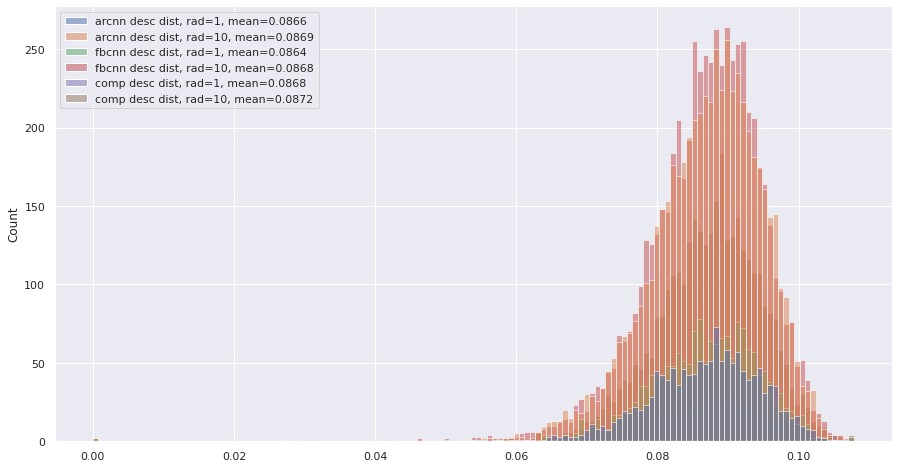

In [ ]:
descriptor_dist = pd.concat([arcnn_1, arcnn_10, fbcnn_1, fbcnn_10, comp_1, comp_10], axis=1)

sns.set(rc={"figure.figsize":(15, 8)})
sns.histplot(data=descriptor_dist)

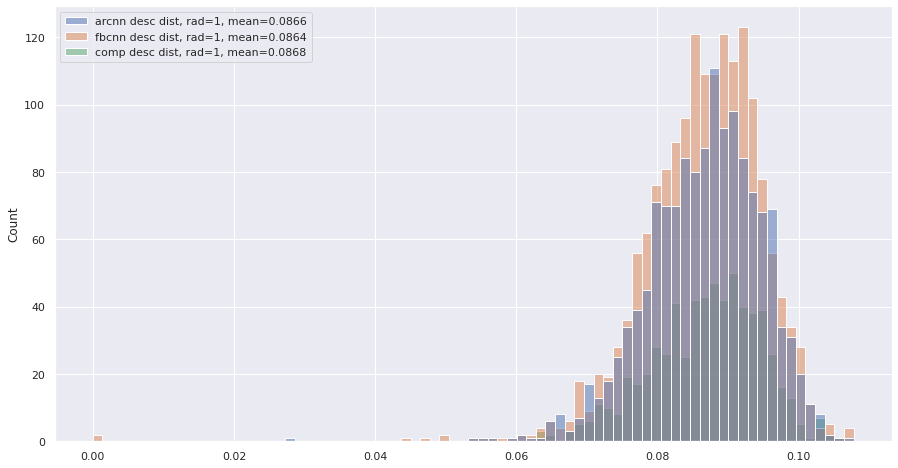

In [ ]:
descriptor_dist = pd.concat([arcnn_1, fbcnn_1, comp_1], axis=1)

sns.set(rc={"figure.figsize":(15, 8)})
sns.histplot(data=descriptor_dist)

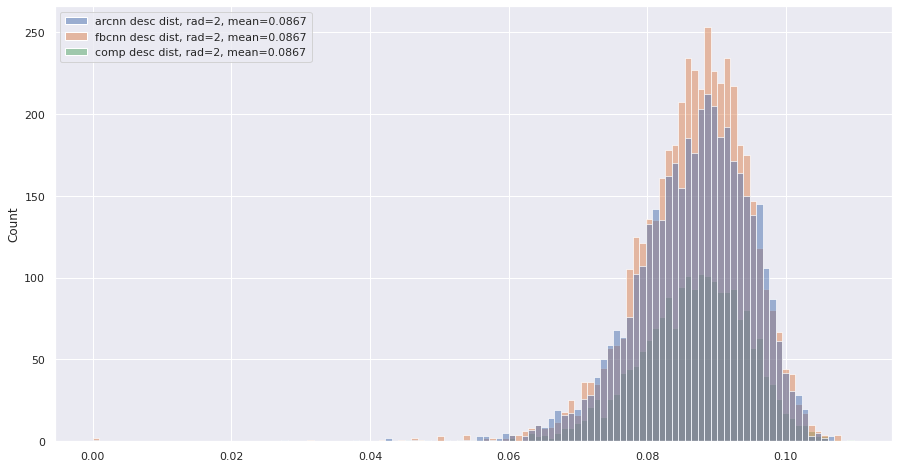

In [ ]:
descriptor_dist = pd.concat([arcnn_2, fbcnn_2, comp_2], axis=1)

sns.set(rc={"figure.figsize":(15, 8)})
sns.histplot(data=descriptor_dist)

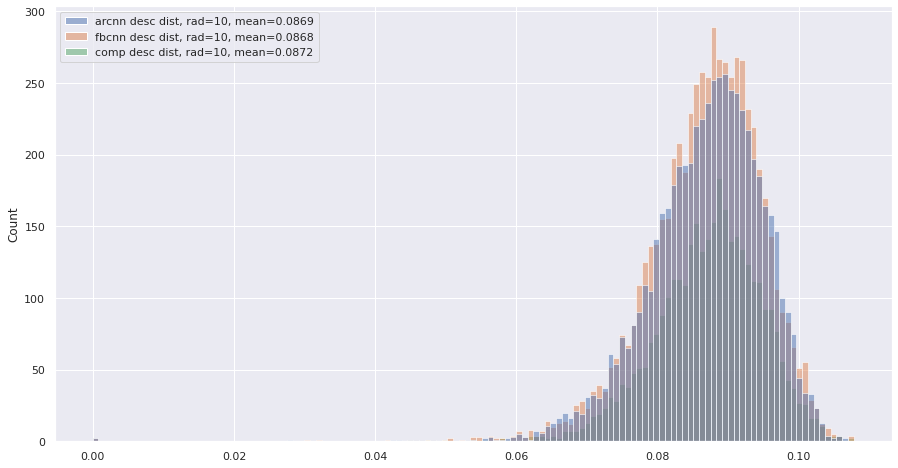

In [ ]:
descriptor_dist = pd.concat([arcnn_10, fbcnn_10, comp_10], axis=1)

sns.set(rc={"figure.figsize":(15, 8)})
sns.histplot(data=descriptor_dist)